<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import gc
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilities import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, KFold
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

pd.options.mode.chained_assignment = None

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Loading the Dataset

In [3]:
df = pd.read_csv('data/network_backup_dataset.csv')

In [4]:
df.head()

,Week #,Day of Week,Backup Start Time - Hour of Day,Work-Flow-ID,File Name,Size of Backup (GB),Backup Time (hour)
0,1,Monday,1,work_flow_0,File_0,0.0,0
1,1,Monday,1,work_flow_2,File_12,0.0,0
2,1,Monday,1,work_flow_2,File_13,0.0,0
3,1,Monday,1,work_flow_2,File_14,0.0,0
4,1,Monday,1,work_flow_2,File_16,0.0,0


In [5]:
df.drop('Backup Time (hour)', axis=1, inplace=True)
df.columns = ['week', 'dow', 'hod', 'id', 'name', 'target']

In [6]:
dayOfWeek={'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df['dow'] = df['dow'].map(dayOfWeek)

In [7]:
features = df.columns.values.tolist()[:5]

lb_en = LabelEncoder()
for feature in features:  # Just label-encode everything.
    df[feature] = lb_en.fit_transform(df[feature])

In [8]:
df.head()

,week,dow,hod,id,name,target
0,0,0,0,0,0,0.0
1,0,0,0,2,4,0.0
2,0,0,0,2,5,0.0
3,0,0,0,2,6,0.0
4,0,0,0,2,8,0.0


## (a)

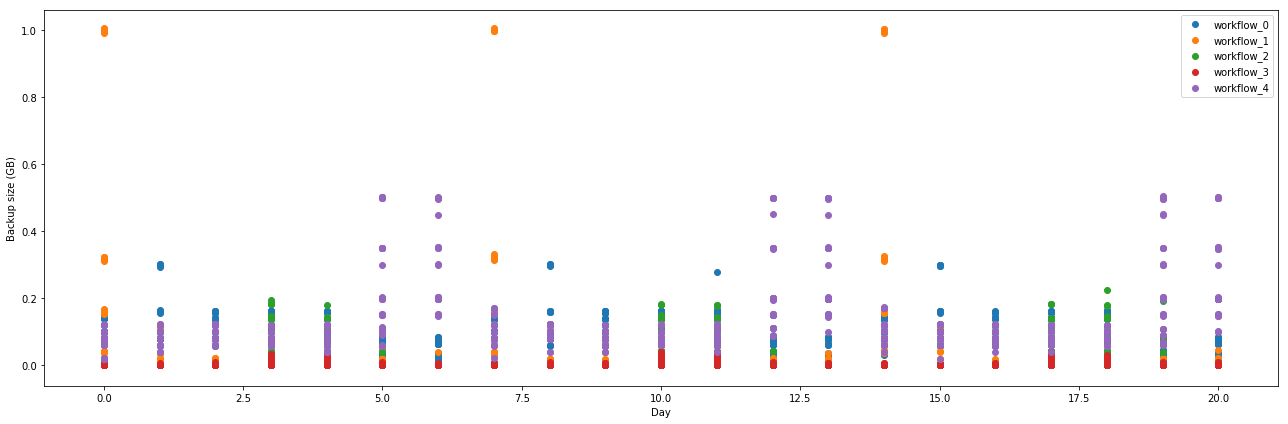

In [91]:
data = df.copy()
data['x'] = df['dow'] + 7*df['week']
data['y'] = df['target']
data = data[data['week']<3]
data = data.groupby('id')

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
for (i, group) in data:
    ax.scatter(group['x'], group['y'], label='workflow_'+str(i))
ax.set_xlabel('Day')
ax.set_ylabel('Backup size (GB)')
ax.legend()

fig.tight_layout()
fig.savefig('report/figures/1-a.png', dpi=300)

## (b)

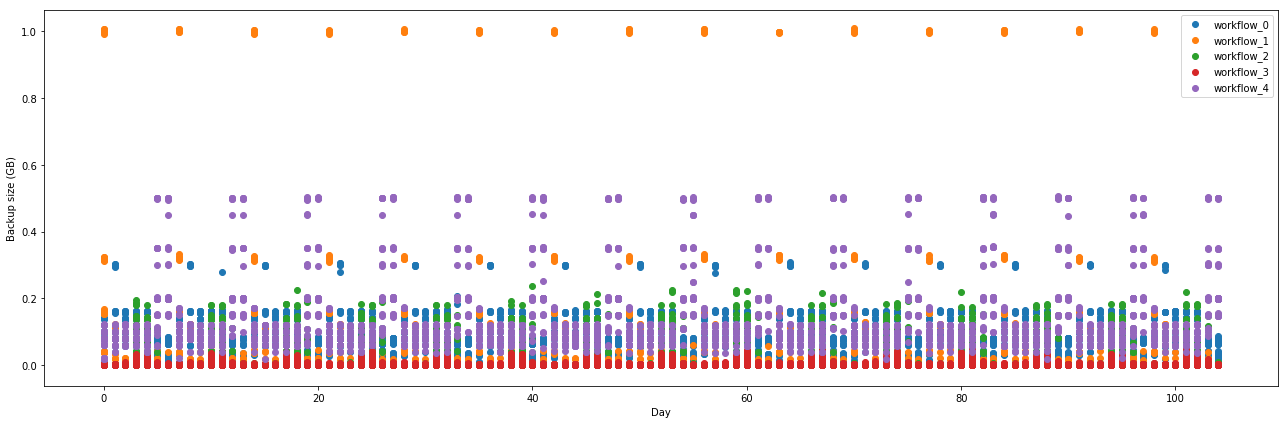

In [90]:
data = df.copy()
data['x'] = df['dow'] + 7*df['week']
data['y'] = df['target']
data = data.groupby('id')


fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
for (i, group) in data:
    ax.scatter(group['x'], group['y'], label='workflow_'+str(i))
ax.set_xlabel('Day')
ax.set_ylabel('Backup size (GB)')
ax.legend()

fig.tight_layout()
fig.savefig('report/figures/1-a.png', dpi=300)

# Predict
## (a) Linear
### i)

In [9]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = LinearRegression()

y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x.values, y.values, clf_lr)  # pass ndarray instead of dataframe
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))

train rmse: 0.101967
test rmse: 0.102391


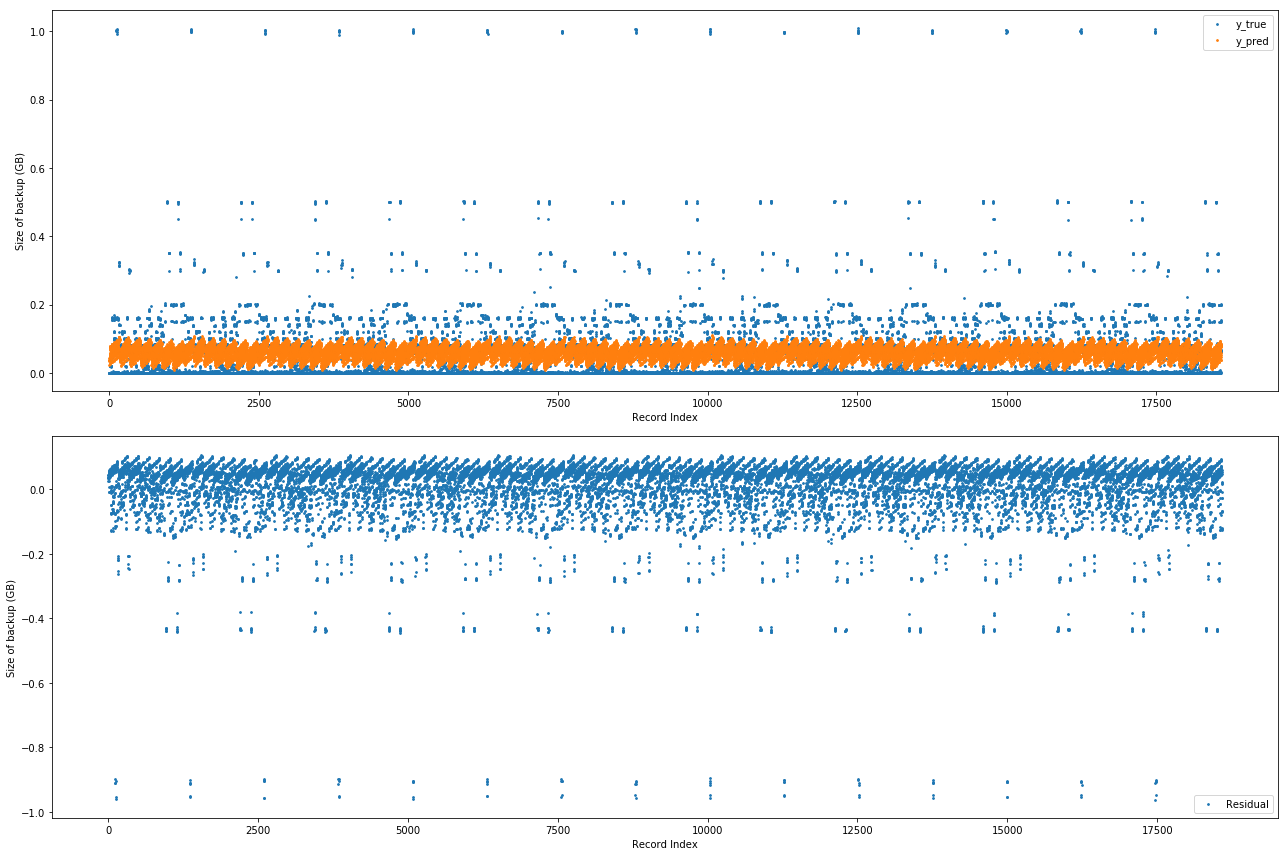

In [31]:
evaluate_results(trn_rmse, tst_rmse, y_true=y, y_pred=y_pred, filename="2-a-i.png")

### ii)

TODO: figure out the difference of standardization and normalization in Sklearn

In [32]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = LinearRegression()

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)  # already an ndarray

y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_scaled, y, clf_lr)
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))

train rmse: 0.101967
test rmse: 0.102391


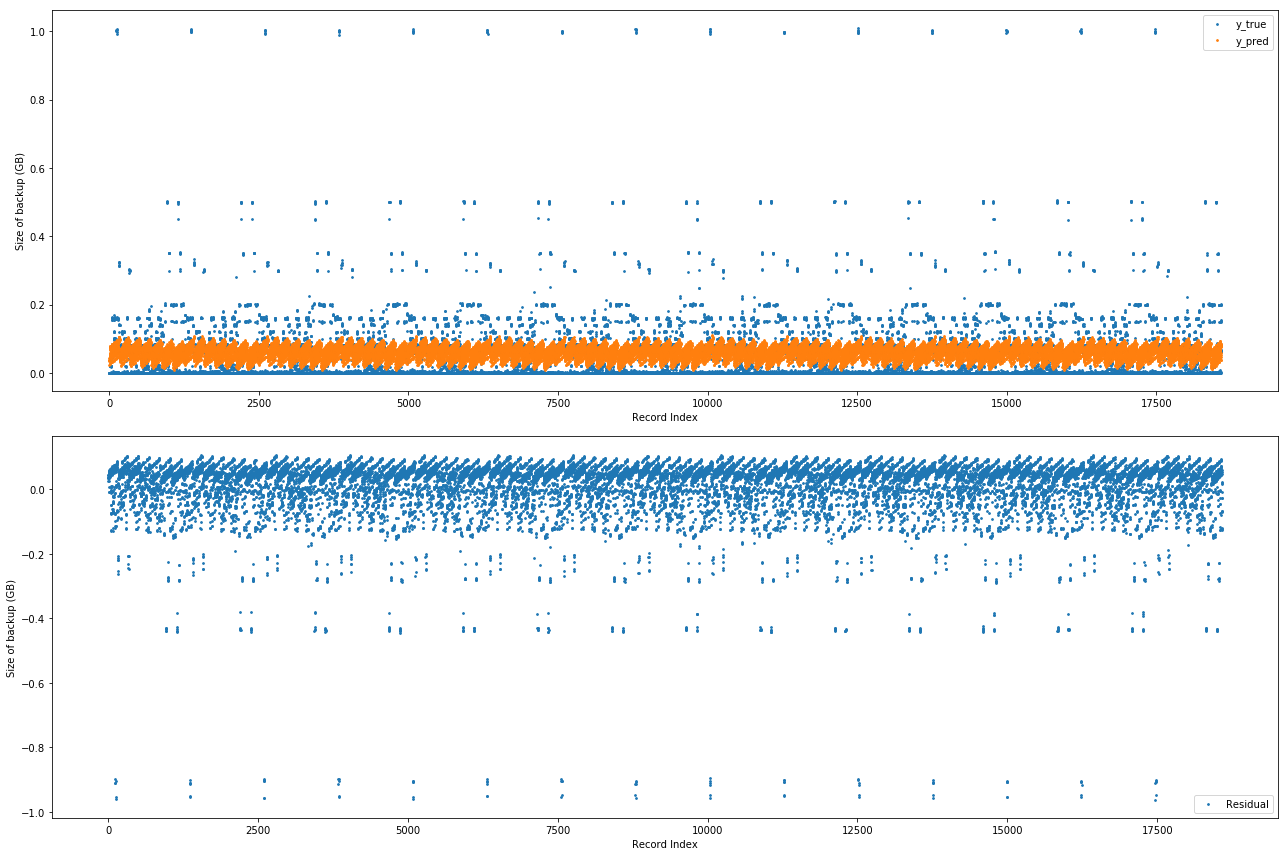

In [33]:
evaluate_results(trn_rmse, tst_rmse, y_true=y, y_pred=y_pred, filename="2-a-ii.png")

### iii)

In [34]:
results = f_regression(x, y)
for i, feature in enumerate(features):
    print("%s fscore: %f and p-value: %.2E" %(feature, results[0][i], results[1][i]))
    
print('% ------------------------------------------------------')

results = mutual_info_regression(x, y, discrete_features=True)
for i, feature in enumerate(features):

    print("%s mutual information score: %f" %(feature, results[i]))

week fscore: 0.008450 and p-value: 9.27E-01
dow fscore: 38.816380 and p-value: 4.76E-10
hod fscore: 150.740934 and p-value: 1.62E-34
id fscore: 26.138665 and p-value: 3.21E-07
name fscore: 460.786474 and p-value: 5.45E-101
% ------------------------------------------------------
week mutual information score: 0.010384
dow mutual information score: 0.236604
hod mutual information score: 0.298921
id mutual information score: 0.767480
name mutual information score: 0.775071


In [35]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = LinearRegression()

x_f_reg = x[['dow', 'hod', 'name']]

y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_f_reg.values, y, clf_lr)
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))

train rmse: 0.101995
test rmse: 0.102402


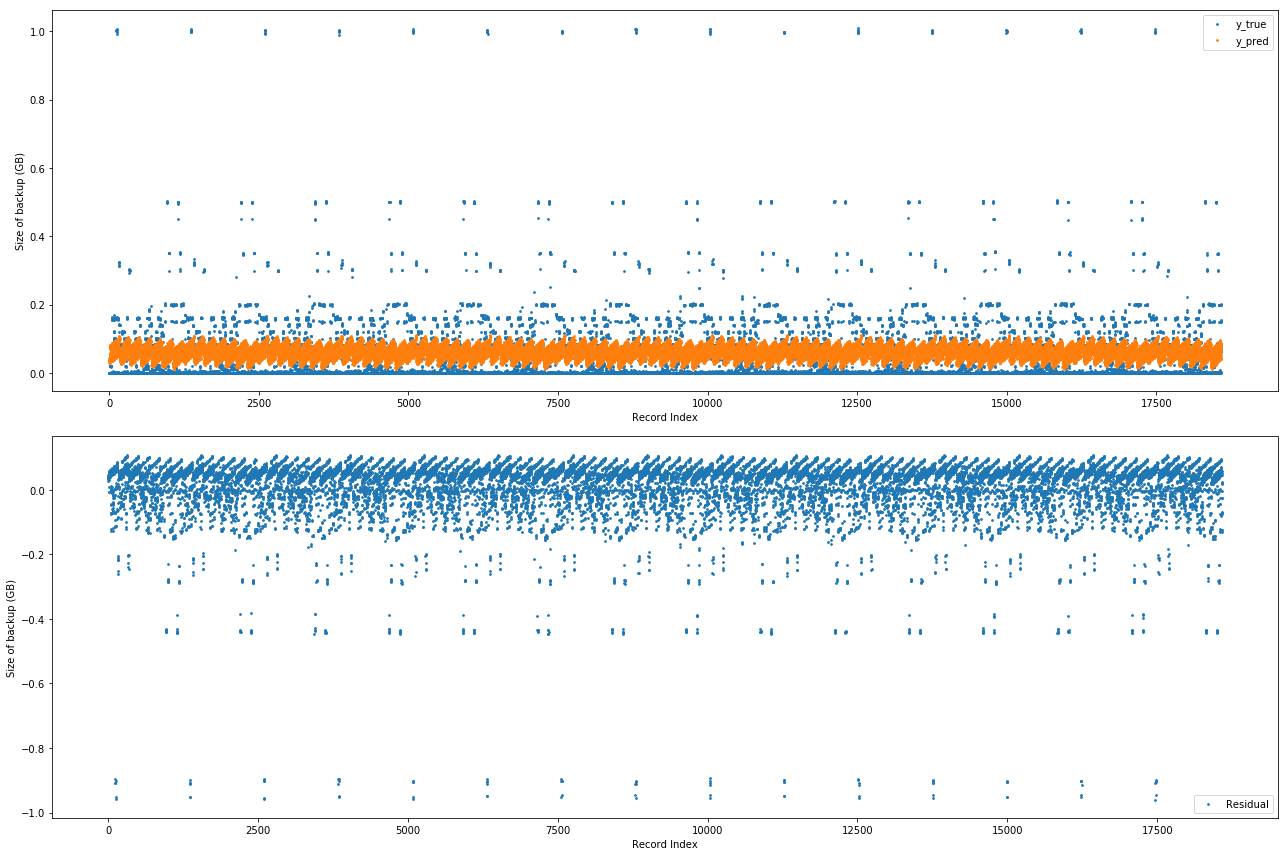

In [36]:
evaluate_results(trn_rmse, tst_rmse, y_true=y, y_pred=y_pred, filename="2-a-iii-freg.png")

In [37]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = LinearRegression()

x_mi = x[['id', 'hod', 'name']]

y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_mi.values, y, clf_lr)
tst_rmse = np.sqrt(mean_squared_error(y, y_pred))

train rmse: 0.102089
test rmse: 0.102489


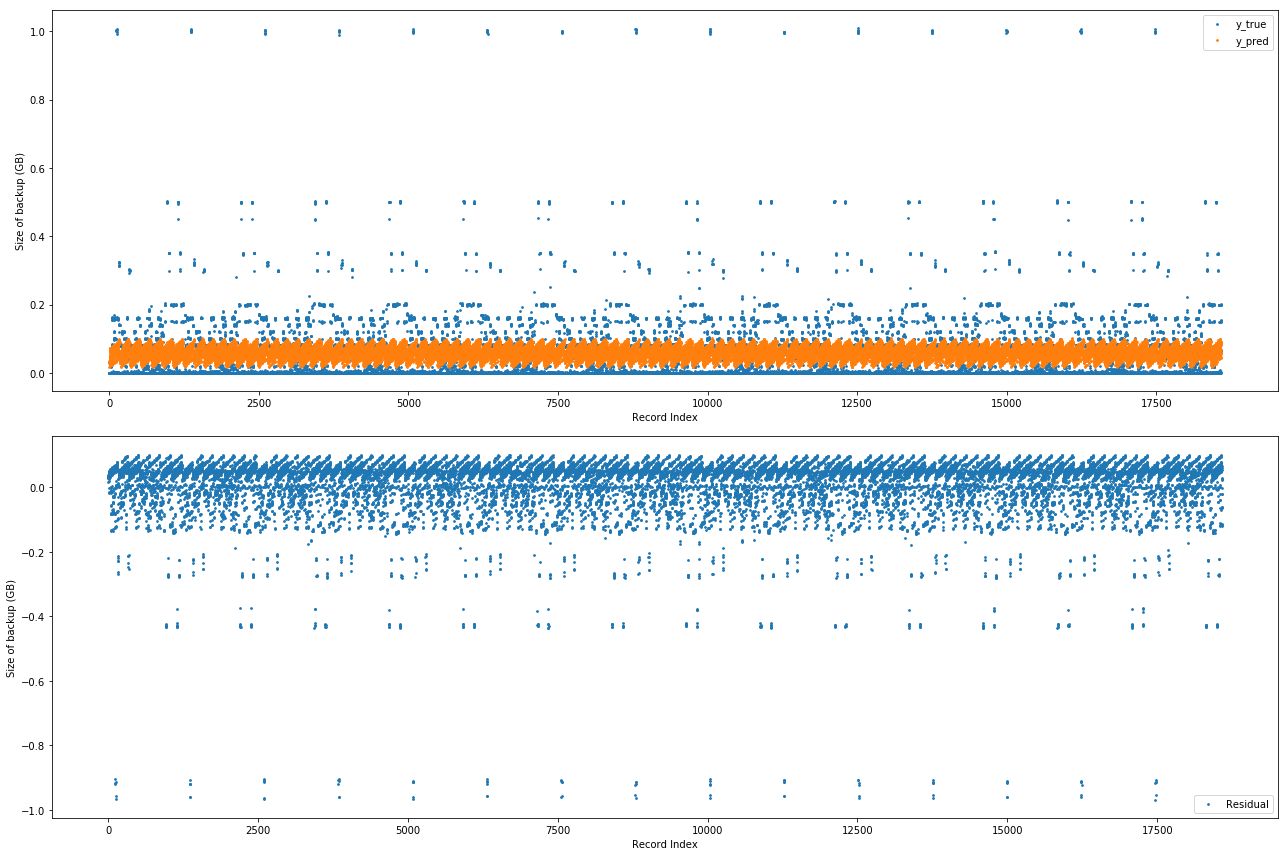

In [38]:
evaluate_results(trn_rmse, tst_rmse, y_true=y, y_pred=y_pred, filename="2-a-iii-mi.png")

### iv)

In [40]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = LinearRegression()

trn_rmses, tst_rmses, feature_sub_collector = find_best_ohe_subsets(nfolds, seed, x, y, features, clf_lr)

ohe that produces best train:  ['dow', 'hod', 'id', 'name']
ohe that produces best test:  ['dow', 'hod', 'id']


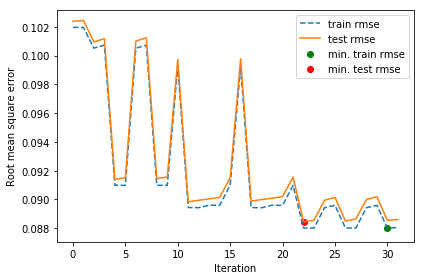

In [41]:
plot_best_ohe_subsets(trn_rmses, tst_rmses, feature_sub_collector, '2-a-iv.png')

### v)

Ridge

ohe that produces best train:  ['week', 'dow', 'hod', 'id', 'name']
ohe that produces best test:  ['dow', 'hod', 'id']


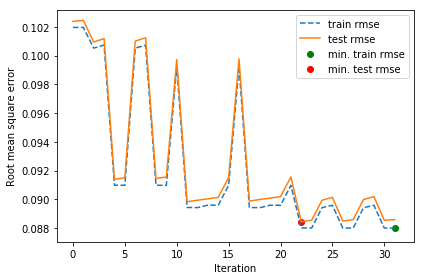

In [38]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = Ridge()

trn_rmses, tst_rmses, feature_sub_collector = find_best_ohe_subsets(nfolds, seed, x, y, features, clf_lr)
plot_best_ohe_subsets(trn_rmses, tst_rmses, feature_sub_collector, '2-a-v-ridge.png')

In [20]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
tst_rmses = np.zeros((len(alphas), ))

x_temp = one_hot_encode(x, ['dow', 'hod', 'id'])

for i, alpha in enumerate(alphas):
    clf_lr = Ridge(alpha=alpha)
    y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_temp.values, y, clf_lr)
    tst_rmses[i] = np.sqrt(mean_squared_error(y, y_pred))

print('best RMSE = %f at alpha = %0.1E' %(np.min(tst_rmses), alphas[np.argmin(tst_rmses)]))

best RMSE = 0.088445 at alpha = 1.0E+01


Lasso

ohe that produces best train:  ['week', 'dow', 'hod', 'id', 'name']
ohe that produces best test:  ['week', 'dow', 'hod', 'id']


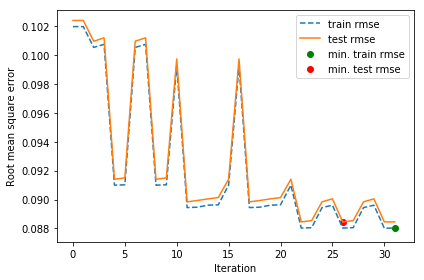

In [12]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = Lasso(alpha=1e-4)

trn_rmses, tst_rmses, feature_sub_collector = find_best_ohe_subsets(nfolds, seed, x, y, features, clf_lr)
plot_best_ohe_subsets(trn_rmses, tst_rmses, feature_sub_collector, '2-a-v-Lasso.png')

In [22]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
alphas = np.arange(1, 11) * 1e-4
tst_rmses = np.zeros((len(alphas), ))

x_temp = one_hot_encode(x, ['week', 'dow', 'hod', 'id'])

for i, alpha in enumerate(alphas):
    clf_lr = Lasso(alpha=alpha)
    y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_temp.values, y, clf_lr)
    tst_rmses[i] = np.sqrt(mean_squared_error(y, y_pred))

print('best RMSE = %f at alpha = %0.1E' %(np.min(tst_rmses), alphas[np.argmin(tst_rmses)]))

best RMSE = 0.088449 at alpha = 1.0E-04


ElasticNet

ohe that produces best train:  ['week', 'dow', 'hod', 'id', 'name']
ohe that produces best test:  ['dow', 'hod', 'id']


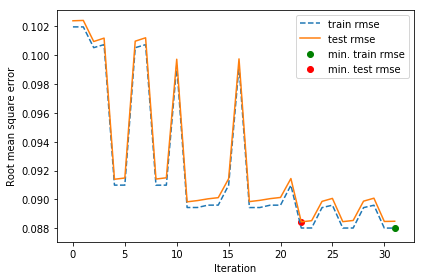

In [23]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
clf_lr = ElasticNet(alpha=1e-4)

trn_rmses, tst_rmses, feature_sub_collector = find_best_ohe_subsets(nfolds, seed, x, y, features, clf_lr)
plot_best_ohe_subsets(trn_rmses, tst_rmses, feature_sub_collector, '2-a-v-ElasticNet.png')

In [30]:
seed = 42
nfolds = 10
x = df[features]
y = df['target']
alphas = np.arange(1, 11) * 1e-4
l1_ratios = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
tst_rmses = []
x_temp = one_hot_encode(x, ['dow', 'hod', 'id'])

for i, (alpha, l1_ratio) in enumerate(zip(alphas,l1_ratios)):
    clf_lr = ElasticNet(alpha)
    y_pred, trn_rmse = cross_validate_custom(nfolds, seed, x_temp.values, y, clf_lr)
    tst_rmses.append(np.sqrt(mean_squared_error(y, y_pred)))
    
print('best RMSE = %f at alpha = %0.1E and l1_ratio = %0.1E' %(np.min(tst_rmses), alphas[np.argmin(tst_rmses)//len(alphas)],
                                                              l1_ratios[np.argmin(tst_rmses)%len(l1_ratios)]))

best RMSE = 0.088446 at alpha = 1.0E-04 and l1_ratio = 1.0E-07


In [33]:
a = Lasso(1e-4)


I:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


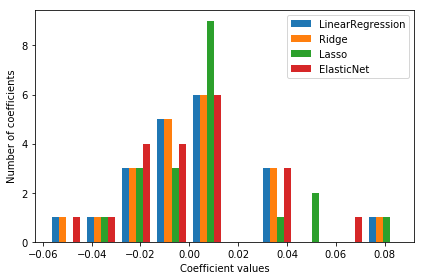

In [50]:
clfs = [LinearRegression(), Ridge(alpha=1e1), Lasso(alpha=1e-4), ElasticNet(alpha=1e-4, l1_ratio=1e-7)]
coefs = []

for i, clf in enumerate(clfs):
    clf.fit(one_hot_encode(x, ['dow', 'hod', 'id']).values, y)
    coefs.append(clf.coef_)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(np.array(coefs).transpose())
ax.legend([type(x).__name__ for x in clfs])
ax.set_xlabel('Coefficient values')
ax.set_ylabel('Number of coefficients')

plt.tight_layout()
plt.savefig('report/figures/2-a-v-coef.png', dpi=300)

## (b) Random Forest

## (c) Neural Network

## (d) Predict each workflow seperately

## (e) kNN